In [1]:
import dynamo as dyn 
import scvelo as scv
import numpy as np 
from scipy.spatial.distance import euclidean 
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from collections import Counter
import re
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
import scvelo as scv
from kneed import KneeLocator
import matplotlib.pyplot as plt
%matplotlib inline
import dynamo as dyn
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from scipy.stats import describe

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
adata=dyn.read_loom('data/a549_tgfb1.loom')
meta=pd.read_csv('data/a549_tgfb1_meta.csv')
adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [3]:
scv.pp.filter_and_normalize(adata, n_top_genes=2000,min_shared_counts=20)
scv.pp.moments(adata)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

Filtered out 28177 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [4]:
#dyn.pp.recipe_monocle(adata, n_top_genes=2000,keep_filtered_genes=True)
#dyn.tl.dynamics(adata, mode='moment')
#dyn.tl.reduceDimension(adata)
#dyn.tl.cell_velocities(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 3567 × 1999 
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [6]:
CellIDs=np.array(meta["Unnamed: 0"])+'x'
for ID in range(len(CellIDs)):
    #This is needed to make the cell ids have the same syntax as the loom files 
    CellIDs[ID]=re.sub('x',"x-",CellIDs[ID],count=1)
    CellIDs[ID]=re.sub('_',":",CellIDs[ID])

meta['Unnamed: 0']=CellIDs

cells=meta['Unnamed: 0'].to_numpy()

treatment=np.array([[meta['Time'][np.squeeze(np.argwhere(cells==cell))]][0] for cell in adata.obs_names])

adata.obsm['treatment']=treatment

adata

AnnData object with n_obs × n_vars = 3567 × 1999 
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'treatment'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [7]:
#emt=['8h','1d','3d','7d']
#stable_emt=['0d','8h','1d','3d','7d']
stable=['0d']

#treatment=np.isin(adata.obsm['treatment'],emt)
#emt_idx=np.squeeze(np.argwhere(treatment==True))

stable=np.isin(adata.obsm['treatment'],stable)
stable_idx=np.squeeze(np.argwhere(stable==True))

adata=adata[stable_idx,:]
adata

View of AnnData object with n_obs × n_vars = 577 × 1999 
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'treatment'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [8]:
X=adata.X.todense()

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,50) 
  
for k in K: 
    if k%5==0:
        print(k)
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(X) 
    kmeanModel.fit(X)     
        
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


5
10
15
20
25
30
35
40
45


16


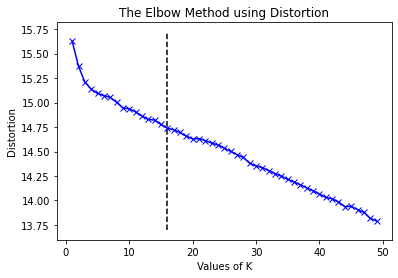

In [9]:
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print(kn.knee) 

plt.plot(K, distortions, 'bx-') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
#plt.xlim([0,20])
plt.show() 

In [10]:
#knee=kn.knee
X=adata.X.todense()

knee=4

kmeans = KMeans(n_clusters=knee,random_state=0).fit(X) 

In [13]:
cluster_centers=kmeans.cluster_centers_

labels=kmeans.labels_

for label in set(labels):
    
    count_matrix=adata.X.todense()
    velocity_matrix=adata.layers['velocity']

    boolean_list=np.argwhere(labels==label).squeeze()

    count_cluster_members=count_matrix[boolean_list]
    velocity_cluster_members=velocity_matrix[boolean_list]
    
    num_members=count_cluster_members.shape[0]
    PCs=round(num_members/10)

    pca_model=PCA(n_components=PCs,random_state=0).fit(count_cluster_members)
    
    count_pcs=pca_model.transform(count_cluster_members)
    velocity_pcs=pca_model.transform(velocity_cluster_members)
    
    print('variance explained using', PCs,' PC\'s in count matrix is',np.sum(pca_model.explained_variance_ratio_))
    print('cluster members:',count_cluster_members.shape[0])
    
    count_matrix_train,count_matrix_test,velocities_train,velocities_test=train_test_split(
                    count_pcs,velocity_pcs,test_size=0.10,random_state=0)
    
    model=LinearRegression().fit(count_matrix_train,velocities_train)
    predicted_velocities = model.predict(count_matrix_test)
    
    diff = predicted_velocities - velocities_test
    diff = np.sum(diff**2, axis=-1)
    
    #dyn.tl.VectorField(adata[boolean_list])
    #dyn.pl.topography(adata)
    print(describe(diff))
    print ()

variance explained using 10  PC's in count matrix is 0.23561572
cluster members: 105
DescribeResult(nobs=11, minmax=(0.09357872, 2.0680392), mean=0.81978583, variance=0.41628784, skewness=0.6263692378997803, kurtosis=-0.8438991700935499)

variance explained using 17  PC's in count matrix is 0.24887443
cluster members: 168
DescribeResult(nobs=17, minmax=(0.084865816, 6.905141), mean=1.6777047, variance=2.826258, skewness=1.8399877548217773, kurtosis=3.5159338363719996)

variance explained using 17  PC's in count matrix is 0.22225398
cluster members: 174
DescribeResult(nobs=18, minmax=(0.07839513, 5.526488), mean=1.3260294, variance=2.1121216, skewness=1.685229778289795, kurtosis=2.148592321218038)

variance explained using 13  PC's in count matrix is 0.22714688
cluster members: 130
DescribeResult(nobs=13, minmax=(0.23564029, 1.9450663), mean=0.7505106, variance=0.20382535, skewness=1.4574158191680908, kurtosis=1.8003879327125976)

